# RNN Implementation of Binary addition

## Contents
1. Generate sample data
2. Build Tensorflow RNN model
3. Train model
4. Calculator wrapper

Can be configured in 32, 16, and 8-bit modes however since the binary addition operation generalizes perfectly for each time step the bitwidth doesn't make much difference. For the same reason very few training examples are required to train the RNN.

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import time
import logging
from IPython import display
from tensorflow.contrib.rnn import BasicRNNCell

print("Tensorflow version: {}".format(tf.__version__))

# Max unsigned integer values
max_uint32 = 2 ** 32 - 1
max_uint16 = 2 ** 16 - 1
max_uint8 = 2 ** 8 - 1

# RNN implementation
# RNN can be implemented using tensorflow api for RNN or by manually unrolling sequence.
use_tf_rnn_api = False

# Adder datatype
# supports
# uint32, uint16 and uint8
dtype = "uint32"

# Hyperparameters
learning_rate = 3e-3
hidden_neurons = 16

# Training data
samples = 256
train_test_batches_split = 0.5
batch_size = 16
epochs = 200

%matplotlib inline  

Tensorflow version: 1.1.0


## 1. Generate Sample data

In [2]:
class SampleData(object):

    def __init__(self, samples, dtype, batch_size, train_test_batches_split):
        valid_dtypes = {"uint8", "uint16", "uint32"}
        if not dtype in valid_dtypes: raise ValueError("input dtype not in valid dtypes")
        if (samples % batch_size != 0): raise ValueError("samples must be multiple of batch_size")
        
        self.dtype = dtype
        
        if dtype == "uint8":
            self.bitwidth = 8
        if dtype == "uint16":
            self.bitwidth = 16
        if dtype == "uint32":
            self.bitwidth = 32
        
        self.x0_uint, self.x1_uint = self.gen_x(samples, dtype)
        self.y_uint = self.calc_y(self.x0_uint, self.x1_uint, dtype)
        
        self.x0_bits = arr2inbits(self.x0_uint)
        self.x1_bits = arr2inbits(self.x1_uint)
        self.y_bits = arr2inbits(self.y_uint)
        self.x0_samples_bits = np.reshape(self.x0_bits, [samples, self.bitwidth])
        self.x1_samples_bits = np.reshape(self.x1_bits, [samples, self.bitwidth])
        self.x_samples_bits_dims = np.dstack([self.x0_samples_bits, self.x1_samples_bits])
        self.y_samples_bits_dims = np.reshape(self.y_bits, [samples, self.bitwidth, 1])
        self.batch_count = int(samples / batch_size)
        self.x_all = np.split(self.x_samples_bits_dims, self.batch_count, axis=0)
        self.y_all = np.split(self.y_samples_bits_dims, self.batch_count, axis=0)
        train_batches = int(train_test_batches_split * self.batch_count)
        test_batches = self.batch_count - train_batches
        self.x_train = self.x_all[:train_batches - 1]
        self.y_train = self.y_all[:train_batches - 1]
        self.x_test = self.x_all[train_batches:]
        self.y_test = self.y_all[train_batches:]
        logging.info("Training set size")
        print("Training set size:")
        self.print_batch_dims(name="x_train", var=self.x_train)
        self.print_batch_dims(name="y_train", var=self.y_train)
        print("Test set size:")
        self.print_batch_dims(name="x_test", var=self.x_test)
        self.print_batch_dims(name="y_test", var=self.y_test)
        
    def gen_x(self, samples, dtype):
        # Would be nice to generate x without replacement however it is too expensive at 32-bit.
        x_init_uint8 = lambda : np.reshape(np.random.choice(max_uint8, samples,
                                                 replace=True).astype(np.uint8), [samples, 1])
        x_init_uint16 = lambda : np.reshape(np.random.choice(max_uint16, samples,
                                                 replace=True).astype(np.uint16), [samples, 1])
        x_init_uint32 = lambda : np.reshape(np.random.choice(max_uint32, samples,
                                                 replace=True).astype(np.uint32), [samples, 1])
        if dtype == "uint8":
            x0_uint = x_init_uint8()
            x1_uint = x_init_uint8()
            temp_x = np.hstack([x0_uint, x1_uint])
        if dtype == "uint16":
            x0_uint = x_init_uint16()
            x1_uint = x_init_uint16()
            temp_x = np.hstack([x0_uint, x1_uint])
        if dtype == "uint32":
            x0_uint = x_init_uint32()
            x1_uint = x_init_uint32()
            temp_x = np.hstack([x0_uint, x1_uint])
        return (x0_uint, x1_uint)
        
    def calc_y(self, x0_uint, x1_uint, dtype):
        temp_x = np.hstack([x0_uint, x1_uint])
        if dtype == "uint8":
            y_uint = np.sum(temp_x, axis=1, dtype=np.uint8)
        if dtype == "uint16":
            y_uint = np.sum(temp_x, axis=1, dtype=np.uint16)
        if dtype == "uint32":
            y_uint = np.sum(temp_x, axis=1, dtype=np.uint32)
        return y_uint
        
    def print_batch_dims(self, name, var):
        print(name + " batches : " + str(len(var)))
        print(name + " batch shape: " + str(var[0].shape))
        
        
    def print_batch(self, batch_no):
        print(self.x[batch_no])

In [3]:
def arr2inbits(x):
    '''
    Function for converting Unsigned bitwidth-bit integers to big endian binary representation.
    Output is flipped so order is lsb to msb
    '''
    x_little_end = x.astype(x.dtype.newbyteorder("B"))
    x_little_end_uint8 = x_little_end.view(np.uint8)
    x_bits = np.unpackbits(x_little_end_uint8)
    x_bits_flipped = x_bits[::-1]
    return x_bits_flipped
def test_arr2inbits():
    x_test = np.array([3,5], dtype="uint32")
    x_test_bits = arr2inbits(x_test)
    assert (x_test_bits == np.array([1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
                                    ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])).all()
    x_test = np.array([3,5], dtype="uint8")
    x_test_bits = arr2inbits(x_test)
    assert (x_test_bits == np.array([1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0])).all()
test_arr2inbits()
def bits2arr(x, dtype):
    x_bits_flipped = x[::-1]
    x_int = np.packbits(x_bits_flipped)
    if dtype == "uint8":
        return x_int
    if dtype == "uint16":
        x_grouped_bytes = np.reshape(x_int, [int(x_int.shape[0] / 2), 2])
        multiplier = np.array([2 ** 8, 1])
    if dtype == "uint32":
        x_grouped_bytes = np.reshape(x_int, [int(x_int.shape[0] / 4), 4])
        multiplier = np.array([2 ** 24, 2 ** 16, 2 ** 8, 1])
    x_weighted_grouped_bytes = multiplier * x_grouped_bytes
    x_int_reduced = np.add.reduce(x_weighted_grouped_bytes, axis=1)
    return x_int_reduced
        
def test_bits2arr():
    x_test = np.array([1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
                                    ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    x_test_int = bits2arr(x_test, "uint32")
    assert(x_test_int == np.array([3,5])).all()
    x_test = np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    x_test_int = bits2arr(x_test, "uint32")
    assert(x_test_int == np.array([256])).all()
test_bits2arr()


In [4]:
train_data = SampleData(samples=samples, 
                        dtype=dtype, 
                        batch_size=batch_size, 
                        train_test_batches_split=train_test_batches_split)

Training set size:
x_train batches : 7
x_train batch shape: (16, 32, 2)
y_train batches : 7
y_train batch shape: (16, 32, 1)
Test set size:
x_test batches : 8
x_test batch shape: (16, 32, 2)
y_test batches : 8
y_test batch shape: (16, 32, 1)


## 2. Build Tensorflow RNN Model

In [5]:
class RnnCell(object):
    def __init__(self, hidden_neurons=16, bitwidth=32, use_tf_rnn_api=True):
        # Tensorflow placeholders
        self.x = tf.placeholder(tf.float32, [None, bitwidth, 2], name="x")
        self.y = tf.placeholder(tf.float32 , [None, bitwidth, 1], name="y")
        self.initial_state = tf.placeholder(tf.float32 , [None, hidden_neurons], name="initial_state")
        
        # Extract time series as list 
        self._x_series = tf.unstack(self.x, axis=1)
        self._y_series = tf.unstack(self.y, axis=1)
        
        # Tensorflow weights and biases
        self._weights, self._bias = {}, {}
        
        # Output layer parameters
        self._weights["h_o"] = tf.Variable(tf.random_uniform([hidden_neurons, 1], -0.1, 0.1),dtype=tf.float32, name="w_h_o")
        self._bias["o"] = tf.Variable(tf.random_uniform([1], -0.1, 0.1), dtype=tf.float32, name="b_o")
        
        # Manual static RNN implementation
        if not use_tf_rnn_api:
            # Input layer parameters
            self._weights["i_h"] = tf.Variable(
                tf.random_uniform([2, hidden_neurons], -0.1, 0.1), dtype=tf.float32, name="w_i_h")

            # Hidden layer parameters 
            self._weights["h_h"] = tf.Variable(
                tf.random_uniform([hidden_neurons, hidden_neurons], -0.1, 0.1), dtype=tf.float32, name="w_h_h")
            self._bias["h"] = tf.Variable(
                tf.random_uniform([hidden_neurons], -0.1, 0.1), dtype=tf.float32, name="b_h")

            h_0 = tf.Variable(np.zeros([1, hidden_neurons]),dtype=tf.float32)
            h_0 = self.initial_state
            self._h, self._logits_series = [], []
            for current_input in self._x_series: 
                # Hidden layer activation is a function of current_inputs, previous hidden layer and bias. 
                temp_h_1 = tf.add(tf.matmul(current_input, self._weights["i_h"]), self._bias["h"])
                h_1 = tf.nn.relu(tf.add(temp_h_1, tf.matmul(h_0, self._weights["h_h"])))
                # Output layer activation is a function of current hidden layer and bias
                o_1_logit = tf.add(tf.matmul(h_1, self._weights["h_o"]), self._bias["o"])
                # Previous hidden layer activation becomes the current hidden layer activation for
                # the next timestep
                self._logits_series.append(o_1_logit)
                self._h.append(h_1)
                h_0 = h_1
        
        # Tensorflow RNN API.  Can use static_rnn or dynamic_rnn in this case.
        else:
            cell = BasicRNNCell(hidden_neurons)
            states, current_state = tf.nn.dynamic_rnn(cell, self.x, initial_state=self.initial_state)
            states_series= tf.unstack(states, axis=1)
            self._logits_series= [tf.add(tf.matmul(state, self._weights["h_o"]), self._bias["o"]) 
                                  for state in states_series]
            
        self.predictions_series = [tf.sigmoid(logits) for logits in self._logits_series]
        predictions_labels = zip(self.predictions_series, self._y_series)
        logits_labels = zip(self._logits_series, self._y_series)
        self._losses = self.cost_func_logits(logits_labels)
        self.total_loss = tf.reduce_mean(self._losses)
        self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(self.total_loss)
    
    def cost_func_logits(self, logits_labels):
        losses = []
        for logits, labels in logits_labels:
            losses.append(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
        return losses

In [6]:
my_rnn = RnnCell(hidden_neurons=hidden_neurons, bitwidth=train_data.bitwidth, use_tf_rnn_api=use_tf_rnn_api)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## 3. Train Model

In [8]:
def train_epoch(sess, rnn, x, y, initial_state):
    total_loss_batch = []
    predictions_batch = []
    _y_series_batch = []
    for batch_no in range(len(x)):
        predictions, _y_series, total_loss, _ = sess.run(
                        [rnn.predictions_series, 
                         rnn._y_series, 
                         rnn.total_loss, 
                         rnn.train_step],
                        feed_dict={
                            rnn.x: x[batch_no],
                            rnn.y: y[batch_no],
                            rnn.initial_state: initial_state
                        })
        total_loss_batch.append(total_loss)
        predictions_batch += predictions
        _y_series_batch += _y_series
    return zip(predictions_batch, _y_series_batch, total_loss_batch)

In [9]:
def predict_epoch(sess, rnn, x, y, initial_state):
    total_loss_batch = []
    predictions_batch = []
    _y_series_batch = []
    for batch_no in range(len(x)):
        predictions, _y_series, total_loss = sess.run(
                        [rnn.predictions_series, 
                         rnn._y_series, 
                         rnn.total_loss],
                        feed_dict={
                            rnn.x: x[batch_no],
                            rnn.y: y[batch_no],
                            rnn.initial_state: initial_state
                        })
        total_loss_batch.append(total_loss)
        predictions_batch += predictions
        _y_series_batch += _y_series
    return zip(predictions_batch, _y_series_batch, total_loss_batch)

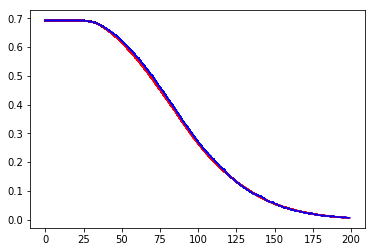

In [10]:
train_total_loss_series_all = []
test_total_loss_series_all = []
predictions_series_all = []
_y_series_series_all = []
init_state = np.zeros([batch_size, hidden_neurons])
for epoch in range(epochs):
    predictions_batch, _y_series_batch, train_total_loss_batch  = zip(*train_epoch(sess=sess, 
                                                                            rnn=my_rnn, 
                                                                            x=train_data.x_train, 
                                                                            y=train_data.y_train,
                                                                            initial_state=init_state))
    predictions_batch, _y_series_batch, test_total_loss_batch  = zip(*predict_epoch(sess=sess, 
                                                                            rnn=my_rnn, 
                                                                            x=train_data.x_test, 
                                                                            y=train_data.y_test,
                                                                            initial_state=init_state))
    train_total_loss_series_all.append(np.mean(train_total_loss_batch))
    test_total_loss_series_all.append(np.mean(test_total_loss_batch))
    plt.plot(range(len(train_total_loss_series_all)), train_total_loss_series_all, "red",
             range(len(test_total_loss_series_all)), test_total_loss_series_all, "blue")
    display.display(plt.gcf())
    display.clear_output(wait=True)

## 4. Calculator Wrapper

In [ ]:
class RNNCalc(object):
    
    
    def __init__(self, dtype, rnn):
        self.rnn = rnn
        if dtype=="uint8":
            self.max_val = 2 ** 8 - 1
            self.dtype = dtype
            self.np_dtype = np.uint8
        if dtype=="uint16":
            self.dtype = dtype
            self.max_val = 2 ** 16 -1
            self.np_dtype = np.uint16
        if dtype=="uint32":
            self.dtype = dtype
            self.max_val = 2 ** 32 -1
            self.np_dtype = np.uint32
        
    def _check_input(self, input_str: str):
        x_unsafe = input(input_str)
        try:
            int(x_unsafe)
        except:
            print("Not an integer!")
            return
        if int(x_unsafe) < 0: 
            print("Input must not be less than 0")
            return
        if int(x_unsafe) > self.max_val: 
            print("Input must not be greater than {}".format(self.max_val))
            return
        x_safe = int(x_unsafe)
        return x_safe

    def run(self):
        while True:
            x0 = self._check_input("Please input x0 in range 0 to {}".format(self.max_val))
            x1 = self._check_input("Please input x1 in range 0 to {}".format(self.max_val))
            if x0 is not None and x1 is not None:
                x0_bits = arr2inbits(np.array((x0,), dtype=self.np_dtype))
                x1_bits = arr2inbits(np.array((x1,), dtype=self.np_dtype))
                x = np.dstack([x0_bits, x1_bits])
                print("x0 int val: {}".format(x0))
                print("x0 bin val: {}".format(x0_bits))
                print("x0 int val: {}".format(x1))
                print("x0 bin val: {}".format(x1_bits))
                predictions= sess.run(
                [self.rnn.predictions_series],
                feed_dict={
                    self.rnn.x: x,
                    self.rnn.initial_state: np.zeros([1, hidden_neurons])
                })
                rounded_predictions = np.around(predictions)
                predictions_cleaned = np.reshape(np.array(rounded_predictions[0]), [32]).astype(self.np_dtype)
                print("y  int val: {} and correct answer is {}"
                      .format(bits2arr(predictions_cleaned, self.dtype)[0], x0 + x1))
                print("y  bin val: {}".format(predictions_cleaned))
                #DO CALCULATION
            user_input = input("Do you wish to perform a new calculation? (y/N)")
            if user_input not in "Yy" :
                break

In [ ]:
my_test_calc = RNNCalc(dtype, my_rnn)
my_test_calc.run()